# Sentimental Analysis using RNN
with SGD/thresholded update/manhattan learning rule

## Manhattan Optimizer

In [ ]:
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer, required
from typing import List, Optional
import numpy as np

count_list = []
last_layer = []
device = 'cpu'

class ManhattanSGD(Optimizer):
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, *, maximize=False, foreach: Optional[bool] = None):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov,
                        maximize=maximize, foreach=foreach)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(ManhattanSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('maximize', False)
            group.setdefault('foreach', None)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs the Manhattan Learning rule such that
        \Delta W(i,j) = sgn(\Delta w(i,j))
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            has_sparse_grad = False

            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        # buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                        #buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()#.mul_(group['lr'])
                        buf = param_state['momentum_buffer'] =  torch.from_numpy(np.where(torch.clone(d_p).cpu().detach()>0, 1, -1)).to(device)
                    else:
                        buf = param_state['momentum_buffer'].float()
                        #buf.mul_(momentum).add_(1 - dampening, d_p)
                        #buf.add_(1 - dampening, torch.from_numpy(np.where(torch.clone(d_p).cpu().detach()>0, 1, -1)).to(device))
                        #buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()#.mul_(group['lr'])
                        buf = param_state['momentum_buffer'] =  torch.from_numpy(np.where(torch.clone(d_p).cpu().detach()>0, 1, -1)).to(device)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                    p.data.add_(-group['lr'], d_p)
                else:
                    p.data.add_(-group['lr'], d_p)


        return loss


## Crossbar

In [ ]:
"""
crossbar.py
Louis Primeau
University of Toronto Department of Electrical and Computer Engineering
louis.primeau@mail.utoronto.ca
July 29th 2020
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import itertools
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import savemat
import torchvision
import torch.optim as optim
import math
from scipy.io import savemat

# Implements scipy's minmax scaler except just between 0 and 1 for torch Tensors.
# Taken from a ptrblck post on the PyTorch forums. Love that dude.
class MinMaxScaler(object):
    def __call__(self, tensor):
        self.scale = 1.0 / (tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0])
        self.min = tensor.min(dim=1, keepdim=True)[0]
        tensor.sub_(self.min).mul_(self.scale)
        return tensor
    def inverse_transform(self, tensor):
        tensor.div_(self.scale).add_(self.min)
        return tensor

In [ ]:
class ticket:
    def __init__(self, row, col, m_rows, m_cols, matrix, mat_scale_factor, crossbar, uvect, decode, inputres, outputres):
        self.row, self.col = row, col
        self.m_rows, self.m_cols = m_rows, m_cols
        self.crossbar = crossbar
        self.mat_scale_factor = mat_scale_factor
        self.matrix = matrix
        self.uvect = uvect
        self.inputres = inputres
        self.adcres = outputres
        self.decode = torch.matmul(self.uvect.t(),self.matrix)

    def prep_vector(self, vector, v_bits):

        # Scale vector to [0, 2^v_bits]
        vect_min = torch.min(vector)
        vector = vector - vect_min
        vect_scale_factor = torch.max(vector) / (2**v_bits - 1)
        vector = vector / vect_scale_factor if vect_scale_factor != 0.0 else vector

        # decompose vector by bit
        bit_vector = torch.zeros(vector.size(0),v_bits)
        bin2s = lambda x : ''.join(reversed( [str((int(x) >> i) & 1) for i in range(v_bits)] ) )
        for j in range(vector.size(0)):
            bit_vector[j,:] = torch.Tensor([float(i) for i in list(bin2s(vector[j]))])
        bit_vector *= self.crossbar.V

        # Pad bit vector with unselected voltages
        pad_vector = torch.zeros(self.crossbar.size[0], v_bits)

        pad_vector[self.row:self.row + self.m_rows,:] = bit_vector

        return pad_vector, vect_scale_factor, vect_min

    def vmm(self, vector):
        # Baseline VMM operation without CODEX
        v_bits = self.inputres
        assert vector.size(1) == 1, "vector wrong shape"

        crossbar = self.crossbar
        # Rescale vector and convert to bits.
        pad_vector, vect_scale_factor, vect_min = self.prep_vector(vector, v_bits)

        rW = self.crossbar.W[0:(self.matrix.shape[0]),0:(2*self.matrix.shape[1])]
        rW = rW[:,1::2] - rW[:,0::2]

        # Perform crossbar VMM
        rV = torch.transpose(pad_vector[0:vector.size(0)],0,1)
        rout = torch.matmul(rV, rW)

        # Round rout to input ADC resolution
        rout_scale_factor = torch.max(rout) / (2**self.adcres - 1)
        rout = rout / rout_scale_factor
        rout = torch.round(rout)
        rout = rout * rout_scale_factor

        # Add binary outputs
        for i in range(rout.size(0)):
            rout[i] *= 2**(v_bits - i - 1)
        rout = torch.sum(rout, axis=0)

        # Rescale binary outputs
        rout = (rout / crossbar.V * vect_scale_factor*self.mat_scale_factor) / 1.5131 + torch.sum(vect_min*self.matrix,axis=0)
        return rout.view(-1,1)

    def CODEXvmm(self, xvector):
        # CODEX VMM operation
        assert xvector.size(1) == 1, "vector wrong shape"
        v_bits=self.inputres
        crossbar = self.crossbar

        #Add encoding vector u to x
        vector = xvector + self.uvect
        pad_vector, vect_scale_factor, vect_min = self.prep_vector(vector, v_bits+1)

        rW = self.crossbar.W[0:(self.matrix.shape[0]),0:(2*self.matrix.shape[1])]
        rW = rW[:,1::2] - rW[:,0::2]

        rV = torch.transpose(pad_vector[0:vector.size(0)],0,1)
        # The rout on the line below this comment contains
        # the raw output currents that the ADC will receive.
        rout = torch.matmul(rV, rW)

        # Round rout to input ADC resolution
        rout_scale_factor = torch.max(rout) / (2**self.adcres - 1)
        rout = rout / rout_scale_factor
        rout = torch.round(rout)
        rout = rout * rout_scale_factor

        for i in range(rout.size(0)):
            rout[i] *= 2**(v_bits - i - 1)
        rout = torch.sum(rout, axis=0)
        rout = 2*(rout / crossbar.V * vect_scale_factor*self.mat_scale_factor) / 1.5231 + torch.sum(vect_min*self.matrix,axis=0)
        rout = rout - self.decode
        return rout.view(-1,1)

    def modified_CODEXvmm(self, xvector):
        # CODEX VMM operation
        assert xvector.size(1) == 1, "vector wrong shape"
        v_bits=self.inputres
        crossbar = self.crossbar

        #Add encoding vector u to x
        vector = xvector + self.uvect
        pad_vector, vect_scale_factor, vect_min = self.prep_vector(vector, v_bits+1)

        rW = self.crossbar.W[0:(self.matrix.shape[0]),0:(2*self.matrix.shape[1])]
        rW = rW[:,1::2] - rW[:,0::2]

        rV = torch.transpose(pad_vector[0:vector.size(0)],0,1)
        # The rout on the line below this comment contains
        # the raw output currents that the ADC will receive.
        rout = torch.matmul(rV, rW)

        # Round rout to input ADC resolution
        rout_scale_factor = torch.max(rout) / (2**self.adcres - 1)
        rout = rout / rout_scale_factor
        rout = torch.round(rout)
        rout = rout * rout_scale_factor

        for i in range(rout.size(0)):
            rout[i] *= 2**(v_bits - i - 1)
        rout = torch.sum(rout, axis=0)
        rout = 2*(rout / crossbar.V * vect_scale_factor*self.mat_scale_factor) / 1.5231 + torch.sum(vect_min*self.matrix,axis=0)

        # do not decode except during inference
        # rout = rout - self.decode
        return rout.view(-1,1)

In [ ]:
import torch.optim as optim
import random
import copy

class linear(torch.autograd.Function):
    #From Louis: Custom pytorch autograd function for crossbar VMM operation
    @staticmethod
    def forward(ctx, ticket, x, W, b):
        ctx.save_for_backward(x, W, b)
        return ticket.CODEXvmm(x) + b

    @staticmethod
    def backward(ctx, dx):
        x, W, b = ctx.saved_tensors
        grad_input = W.t().mm(dx)
        grad_weight = dx.mm(x.t())
        grad_bias = dx
        return (None, grad_input, grad_weight, grad_bias)

class Linear(torch.nn.Module):
    def __init__(self, input_size, output_size, cb,uvect):
        super(Linear, self).__init__()
        self.W = torch.nn.parameter.Parameter(torch.rand(output_size, input_size))
        self.b = torch.nn.parameter.Parameter(torch.rand(output_size, 1))
        self.cb = cb

        #Instantiate Linear layer with pool of random encoding vectors to sample from
        self.uvectlist = uvect
        self.uvectidx = 0
        # Decoding vector is calculated ideally here off-chip, but calculating decoding vector on-chip is also possible
        self.decode = torch.matmul(self.uvectlist[self.uvectidx].t(),torch.transpose(self.W,0,1)).detach().clone()
        self.ticket = cb.register_linear(torch.transpose(self.W,0,1),self.uvectlist[self.uvectidx],self.decode)
        self.f = linear()
        self.cbon = False

    def forward(self, x):
        return self.f.apply(self.ticket, x, self.W, self.b) if self.cbon else self.W.matmul(x) + self.b

    def remap(self):
        #Should call the remap crossbar function after 1 or a couple update steps
        self.cb.clear()
        self.ticket = self.cb.register_linear(torch.transpose(self.W,0,1),self.uvectlist[self.uvectidx],self.decode)

    def update_decode(self):
        #Update decoding vector by updating U*G.
        self.decode = torch.matmul(self.uvectlist[self.uvectidx].t(),torch.transpose(self.W,0,1)).detach().clone()

    def resample(self):
        #Sample random new uvector from provided uvectlist
        self.cb.clear()
        self.uvectidx = random.randint(0, len(uvectlist)-1)
        self.ticket = self.cb.register_linear(torch.transpose(self.W,0,1),self.uvectlist[self.uvectidx],self.decode)

    def use_cb(self, state):
        self.cbon = state


In [ ]:
# Key Idea is that CODEX allows us to use higher ADC inpt resolution by
# Reducing the ADC sensing range.
device_params = {"Vdd": 1.8,
                 "r_wl": 20,
                 "r_bl": 20,
                 "m": 200,
                 "n": 200,
                 "r_on_mean": 1e4,
                 "r_on_stddev": 1e3,
                 "r_off_mean": 1e5,
                 "r_off_stddev": 1e4,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 6,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01}


class crossbar:
    def __init__(self, device_params):

        # Power Supply Voltage
        self.V = device_params["Vdd"]

        # DAC resolution
        self.input_resolution = device_params["dac_resolution"]
        self.output_resolution = device_params["adc_resolution"]

        # Wordline Resistance
        self.r_wl = torch.Tensor((device_params["r_wl"],))
        # Bitline Resistance
        self.r_bl = torch.Tensor((device_params["r_bl"],))

        # Number of rows, columns
        self.size = device_params["m"], device_params["n"]

        # High resistance state
        self.g_on = 1 / torch.normal(device_params["r_on_mean"], device_params["r_on_stddev"], size=self.size)
        #self.g_on = (1 / device_params["r_on_mean"]) * torch.ones(self.size)

        # Low Resistance state
        self.g_off = 1 / torch.normal(device_params["r_off_mean"], device_params["r_off_stddev"], size=self.size)
        #self.g_off = (1 / device_params["r_off_mean"]) * torch.ones(self.size)

        self.g_wl = torch.Tensor((1 / device_params["r_wl"],))
        self.g_bl = torch.Tensor((1 / device_params["r_bl"],))

        # Resolution
        self.resolution = device_params["device_resolution"]
        # Conductance tensor, m x n x 2**resolution

        # 2**self.resolution - 1 so that there's a conductance state in the middle.
        self.conductance_states = torch.cat([torch.cat([torch.linspace(self.g_off[i,j], self.g_on[i,j],2**self.resolution - 1).unsqueeze(0)
                                                        for j in range(self.size[1])],dim=0).unsqueeze(0)
                                             for i in range(self.size[0])],dim=0)

        # Bias Scheme
        self.bias_voltage = self.V * device_params["bias_scheme"]

        # Tile size (1x1 = 1T1R, nxm = passive, etc.)
        self.tile_rows = device_params["tile_rows"]
        self.tile_cols = device_params["tile_cols"]
        assert self.size[0] % self.tile_rows == 0, "tile size does not divide crossbar size in row direction"
        assert self.size[1] % self.tile_cols == 0, "tile size does not divide crossbar size in col direction"

        # Resistance of CMOS lines
        self.r_cmos_line = device_params["r_cmos_line"]

        # Conductance Matrix; initialize each memristor at the on resstance
        self.W = torch.ones(self.size) * self.g_on

        # Stuck-on & stuck-on device nonideality
        self.p_stuck_on = device_params["p_stuck_on"]
        self.p_stuck_off = device_params["p_stuck_off"]
        self.devicefaults = False

        self.mapped = []

        self.saved_tiles = {}

    def apply_stuck(self, p_stuck_on, p_stuck_off):

        state_dist = torch.distributions.categorical.Categorical(probs=torch.Tensor([p_stuck_on, p_stuck_off, 1 - p_stuck_on - p_stuck_off]))
        state_mask = state_dist.sample(self.size)

        self.W[state_mask == 0] = self.g_off[state_mask==0]
        self.W[state_mask == 1] = self.g_on[state_mask==1]

        return None

    def map(self, matrix):
        assert not(matrix.size(0) > self.size[0] or matrix.size(1)*2 > self.size[1]), "input too large"
        midpoint = self.conductance_states.size(2) // 2

        for i in range(matrix.size(0)):
            for j in range(matrix.size(1)):

                shifted = self.conductance_states[i,j] - self.conductance_states[i,j,midpoint]
                idx = torch.min(torch.abs(shifted - matrix[i,j]), dim=0)[1]

                self.W[i,2*j+1] = self.conductance_states[i,j,idx]
                self.W[i,2*j] = self.conductance_states[i,j,midpoint-(idx-midpoint)]

    def solve(self, voltage):
        output = torch.zeros((voltage.size(1), self.size[1]))
        for i in range(self.size[0] // self.tile_rows):
            for j in range(self.size[1] // self.tile_cols):
                for k in range(voltage.size(1)):
                    coords = (i*self.tile_rows, (i+1)*self.tile_rows, j*self.tile_cols, (j+1)*self.tile_rows)
                    vect = voltage[i*self.tile_rows:(i+1)*self.tile_rows,k]
                    solution = self.circuit_solve(coords, vect, torch.zeros(self.size[1]), torch.ones(self.size[1]), torch.zeros(self.size[0]))
                    output[k] += torch.cat((torch.zeros(j*self.tile_cols), solution, torch.zeros((self.size[1] // self.tile_cols - j - 1) * self.tile_cols)))
        return output

    """
    A Comprehensive Crossbar Array Model With Solutions for Line Resistance and Nonlinear Device Characteristics
    An Chen
    IEEE TRANSACTIONS ON ELECTRON DEVICES, VOL. 60, NO. 4, APRIL 2013
    """

    def hash_M(self, a, b, c, d):
        return str(a) + "_" + str(b) + "_" + str(c) + "_" + str(d)

    def make_M(self, a, b, c, d):

        conductances = self.W[a:b,c:d]
        g_wl, g_bl = self.g_wl, self.g_bl
        g_s_wl_in, g_s_wl_out = torch.ones(self.tile_rows) * 1, torch.ones(self.tile_rows) * 1e-9
        g_s_bl_in, g_s_bl_out = torch.ones(self.tile_rows) * 1e-9, torch.ones(self.tile_rows) * 1
        m, n = self.tile_rows, self.tile_cols

        A = torch.block_diag(*tuple(torch.diag(conductances[i,:])
                          + torch.diag(torch.cat((g_wl, g_wl * 2 * torch.ones(n-2), g_wl)))
                          + torch.diag(g_wl * -1 *torch.ones(n-1), diagonal = 1)
                          + torch.diag(g_wl * -1 *torch.ones(n-1), diagonal = -1)
                          + torch.diag(torch.cat((g_s_wl_in[i].view(1), torch.zeros(n - 2), g_s_wl_out[i].view(1))))
                                   for i in range(m)))

        B = torch.block_diag(*tuple(-torch.diag(conductances[i,:]) for i in range(m)))

        def makec(j):
            c = torch.zeros(m, m*n)
            for i in range(m):
                c[i,n*(i) + j] = conductances[i,j]
            return c

        C = torch.cat([makec(j) for j in range(n)],dim=0)

        def maked(j):
            d = torch.zeros(m, m*n)

            def c(k):
                return(k - 1)

            i = 1
            d[c(i),c(j)] = -g_s_bl_in[c(j)] - g_bl - conductances[c(i),c(j)]
            d[c(i), n*i + c(j)] = g_bl

            i = m
            d[c(i), n*(i-2) + c(j)] = g_bl
            d[c(i), n*(i-1) + c(j)] = -g_s_bl_out[c(j)] - conductances[c(i),c(j)] - g_bl

            for i in range(2, m):
                d[c(i), n*(i-2) + c(j)] = g_bl
                d[c(i), n*(i-1) + c(j)] = -g_bl - conductances[c(i),c(j)] - g_bl
                d[c(i), n*(i+1) + c(j)] = g_bl

            return d

        D = torch.cat([maked(j) for j in range(1,n+1)], dim=0)

        M = torch.cat((torch.cat((A,B),dim=1), torch.cat((C,D),dim=1)), dim=0)

        self.saved_tiles[self.hash_M(a,b,c,d)] = M

        return torch.inverse(M)

    def circuit_solve(self, coords,  v_wl_in, v_bl_in, v_bl_out, v_wl_out):

        g_wl, g_bl = self.g_wl, self.g_bl
        g_s_wl_in, g_s_wl_out = torch.ones(self.tile_rows) * 1, torch.ones(self.tile_rows) * 1e-9
        g_s_bl_in, g_s_bl_out = torch.ones(self.tile_rows) * 1e-9, torch.ones(self.tile_rows) * 1
        m, n = self.tile_rows, self.tile_cols


        if self.hash_M(*coords) not in self.saved_tiles.keys():
            #print(coords)
            M = self.make_M(*coords)
        else:
            M = self.saved_tiles[self.hash_M(*coords)]

        E = torch.cat([torch.cat(((v_wl_in[i]*g_s_wl_in[i]).view(1), #EW
                                  torch.zeros(n-2),
                                  (v_wl_out[i]*g_s_wl_out[i]).view(1)))
                                 for i in range(m)] +
                      [torch.cat(((-v_bl_in[i]*g_s_bl_in[i]).view(1), #EB
                                  torch.zeros(m-2),
                                  (-v_bl_in[i]*g_s_bl_out[i]).view(1)))
                                 for i in range(n)]
        ).view(-1, 1)

        V = torch.matmul(M, E)

        V = torch.chunk(torch.solve(E, M)[0], 2)

        return torch.sum((V[1] - V[0]).view(m,n)*self.W[coords[0]:coords[1],coords[2]:coords[3]],dim=0)

    def register_linear(self, matrix, uvectlist, decode, bias=None):

        row, col = self.find_space(matrix.size(0), matrix.size(1))
        # Need to add checks for bias size and col size

        # Scale matrix
        mat_scale_factor = torch.max(torch.abs(matrix)) / torch.max(self.g_on) * 2
        scaled_matrix = matrix / mat_scale_factor

        midpoint = self.conductance_states.size(2) // 2
        for i in range(row, row + scaled_matrix.size(0)):
            for j in range(col, col + scaled_matrix.size(1)):

                shifted = self.conductance_states[i,j] - self.conductance_states[i,j,midpoint]
                idx = torch.min(torch.abs(shifted - scaled_matrix[i-row,j-col]), dim=0)[1]
                self.W[i,2*j+1] = self.conductance_states[i,j,idx]
                self.W[i,2*j] = self.conductance_states[i,j,midpoint-(idx-midpoint)]

        return ticket(row, col, matrix.size(0), matrix.size(1), matrix, mat_scale_factor, self, uvectlist, decode, self.input_resolution, self.output_resolution)

    def which_tiles(self, row, col, m_row, m_col):
        return itertools.product(range(row // self.tile_rows, (row + m_row) // self.tile_rows + 1),
                                 range(col // self.tile_cols,(col + m_col) // self.tile_cols + 1),
        )

    def find_space(self, m_row, m_col):
        if not self.mapped:
            self.mapped.append((0,0,m_row,m_col))
        else:
            self.mapped.append((self.mapped[-1][0] + self.mapped[-1][2], self.mapped[-1][1] + self.mapped[-1][3], m_row, m_col))
        return self.mapped[-1][0], self.mapped[-1][1]

    def clear(self):
        self.mapped = []
        self.W = torch.ones(self.size) * self.g_on

    def conductance_update(self):
        self.conductance_states = torch.cat([torch.cat([torch.linspace(self.g_off[i,j], self.g_on[i,j],2**self.resolution - 1).unsqueeze(0)
                                                        for j in range(self.size[1])],dim=0).unsqueeze(0)
                                             for i in range(self.size[0])],dim=0)

## RNN

In [ ]:
import csv

# file location (make sure to use your file location)
file_dir = '/content/'

# load csv file
def get_data():
    return csv.reader(open(file_dir + "training.1600000.processed.noemoticon.csv","rt", encoding="latin-1"))

import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50)

def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

import torch
import torch.nn as nn

def get_tweet_vectors(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        tweet = line[-1]
        if i % 59 == 0:
            # obtain an embedding for the entire tweet
            tweet_emb = sum(glove_vector[w] for w in split_tweet(tweet))
            # generate a label: 1 = happy, 0 = sad
            label = torch.tensor(int(line[0] == "4")).long()
            # place the data set in either the training, validation, or test set
            if i % 5 < 3:
                train.append((tweet_emb, label)) # 60% training
            elif i % 5 == 4:
                valid.append((tweet_emb, label)) # 20% validation
            else:
                test.append((tweet_emb, label)) # 20% test
    return train, valid, test

glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000)

.vector_cache/glove.6B.zip: 862MB [02:38, 5.43MB/s]                           
100%|█████████▉| 9999/10000 [00:00<00:00, 50105.91it/s]


In [ ]:
import torchtext

glove = torchtext.vocab.GloVe(name="6B", dim=50)

train, valid, test = get_tweet_vectors(glove)

train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)

In [ ]:
def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        if i % 29 == 0:
            tweet = line[-1]
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_tweet(tweet)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = torch.tensor(int(line[0] == "4")).long()
            if i % 5 < 3:
                train.append((idxs, label))
            elif i % 5 == 4:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
    return train, valid, test

train, valid, test = get_tweet_words(glove)

In [ ]:
import matplotlib.pyplot as plt

def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        i = 0
        for tweets, labels in train:
            i += 1
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            if i % 100 == 1:
                train_acc.append(get_accuracy(model, train_loader))
                valid_acc.append(get_accuracy(model, valid_loader))
                print("Epoch %d; Iteration %d; Loss %f; Train Acc %f; Val Acc %f" % (
                      epoch+1, i, loss, train_acc[-1], valid_acc[-1]))
                with open('log_baseline_test2.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([epoch * 100 + i, loss, valid_acc[-1]])

        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("End of Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### SGD-only

In [ ]:
def net_trainer2(model, train_dataloader, test_dataloader, config):
    model.train()
    avg_loss = -1
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
    #ManhattanSGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
    #optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
    criterion = nn.CrossEntropyLoss()

    def local_sched(learning_rate, gamma, cur_avg_abs_grad, epoch_n):
        new_thr = cur_avg_abs_grad*(1+(math.exp(-learning_rate*gamma*epoch_n)))
        upper_bound = cur_avg_abs_grad * config['max_thresh_multiplier']

        return min(new_thr, upper_bound)

    torch.manual_seed(0)
    update_per_epoch = []
    loss_per_epoch = []
    every_loss = []
    #thr_per_batch = []

    for j in range(config['num_epochs']):
        data, target = next(iter(train_dataloader))
        optimizer.zero_grad()

        cur_epoch_updates = 0

        for batch_idx, (data, target) in enumerate(train_dataloader):

            if batch_idx % config['test_interval'] == 1:
                print(f"Test accuracy: {network_tester(model, test_dataloader, 500, j)}")

            if batch_idx % config['log_interval'] == 1:
                print(f"Epoch: {j + 1}, Loss: {loss.data} Updates: {cur_epoch_updates}/{batch_idx}, Avg Grad: {cur_avg_abs_grad}0")
                with open('log_baseline_train2.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([batch_idx + j * 32000, loss.data.item(), network_tester(model, train_dataloader, 100, j, False).item()])

                with open('record.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([batch_idx + 32000 * (j), cur_epoch_updates, cur_avg_abs_grad.item(), 0])

                #save_model(model)


            output = model(data)
            #print(output)
            #curr_loss = criterion(output, target) / config['batch_size']
            loss = F.nll_loss(output, target) / config['batch_size']
            loss.backward(retain_graph=True)
            every_loss.append(loss.data)

            if batch_idx % config['batch_size'] == 0:
                #print("batch id:", batch_idx)
                cur_avg_abs_grad = model.fc1.W.grad.abs().mean()

                # this is kind of hardcoded... Are we doing num_layers in this search?
                # we want to perform searches on things that don't really affect the
                # effectivity of thresholding, so maybe not
                # perhaps let's do ADC resolution + learning rate?
                cur_epoch_updates += 1
                # cur_lr = get_current_lr(optimizer, 0, 0)
                optimizer.step()
                model.fc1.remap()

                #netowrk.fc2.remap()
                optimizer.zero_grad()
                avg_loss = -1.0


        update_per_epoch.append(cur_epoch_updates)


        loss_per_epoch.append(loss.data)
    return loss_per_epoch, update_per_epoch, every_loss, []

### Thresholded update

In [ ]:
def net_trainer(model, train_dataloader, test_dataloader, config):
    model.train()
    avg_loss = -1
    threshold_update = False
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
    criterion = nn.CrossEntropyLoss()

    def local_sched(learning_rate, gamma, cur_avg_abs_grad, epoch_n):
        new_thr = cur_avg_abs_grad*(1+(math.exp(-learning_rate*gamma*epoch_n)))
        upper_bound = cur_avg_abs_grad * config['max_thresh_multiplier']

        return min(new_thr, upper_bound)

    torch.manual_seed(0)
    update_per_epoch = []
    loss_per_epoch = []
    every_loss = []
    thr_per_batch = []

    for j in range(config['num_epochs']):
        data, target = next(iter(train_dataloader))
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward(retain_graph=True)
        optimizer.step()
        cur_avg_abs_grad = model.fc1.W.grad.abs().mean()
        init_thr = local_sched(config['learning_rate'], config['gamma'],
                               cur_avg_abs_grad, j+1)
        thr = init_thr
        cur_epoch_updates = 0

        for batch_idx, (data, target) in enumerate(train_dataloader):

            if batch_idx % config['test_interval'] == 0:
                print(f"Test accuracy: {network_tester(model, test_dataloader, 400, j)}")

            if batch_idx % config['log_interval'] == 0:
                print(f"Epoch: {j + 1}, Loss: {loss.data} Updates: {cur_epoch_updates}/{batch_idx}, Avg Grad: {cur_avg_abs_grad}, Threshold: {thr}")
                with open('log_baseline_train3.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([batch_idx + j * config['log_interval'], loss.data.item(), network_tester(model, train_dataloader, 100, j, False).item()])

                with open('record3.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([batch_idx + config['log_interval'] * (j), cur_epoch_updates, cur_avg_abs_grad.item(), thr.item()])


            output = model(data)
            #print(output)
            #curr_loss = criterion(output, target) / config['batch_size']
            loss = F.nll_loss(output, target) / config['batch_size']
            loss.backward(retain_graph=True)
            every_loss.append(loss.data)


            if avg_loss == -1.0:
                avg_loss = loss
            else:
                avg_loss += loss
            if avg_loss > config['naive_loss_thr']:
                thr = init_thr

            if batch_idx % config['batch_size'] == 0:
                cur_avg_abs_grad = model.fc1.W.grad.abs().mean()
                if threshold_update:
                    thr = local_sched(config['learning_rate'],
                                                    config['gamma'], cur_avg_abs_grad, batch_idx+1)
                    threshold_update = False
                # this is kind of hardcoded... Are we doing num_layers in this search?
                # we want to perform searches on things that don't really affect the
                # effectivity of thresholding, so maybe not
                # perhaps let's do ADC resolution + learning rate?
                if cur_avg_abs_grad > thr:
                    cur_epoch_updates += 1
                    # cur_lr = get_current_lr(optimizer, 0, 0)
                    # thr = local_sched(config['learning_rate'],
                    #                                 config['gamma'], cur_avg_abs_grad, batch_idx+1)
                    optimizer.step()
                    model.fc1.remap()
                    #netowrk.fc2.remap()
                    optimizer.zero_grad()
                    threshold_update = True
                avg_loss = -1.0
                thr_per_batch.append(thr)


        update_per_epoch.append(cur_epoch_updates)


        loss_per_epoch.append(loss.data)
    return loss_per_epoch, update_per_epoch, every_loss, thr_per_batch

def network_tester(model, test_loader, test_size, epoch, log = True ):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if batch_idx * len(data) > test_size:
                break
            output = model(data)
            loss = F.nll_loss(output, target)

            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            total+=target.size(0)

            if batch_idx % 100 == 0 and log:
              with open('log_baseline_test3.csv', 'a') as f:
                writer = csv.writer(f)
                writer.writerow([batch_idx + epoch * 600, test_loss/(batch_idx+1), correct.item()/total])
              print("Epoch", epoch, 'iteration',batch_idx, 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                          % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    return torch.div(correct, float(total))

### Manhattan Learning Rule

In [ ]:
def net_trainer3(model, train_dataloader, test_dataloader, config):
    model.train()
    avg_loss = -1
    optimizer = ManhattanSGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
    #optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
    criterion = nn.CrossEntropyLoss()

    def local_sched(learning_rate, gamma, cur_avg_abs_grad, epoch_n):
        new_thr = cur_avg_abs_grad*(1+(math.exp(-learning_rate*gamma*epoch_n)))
        upper_bound = cur_avg_abs_grad * config['max_thresh_multiplier']

        return min(new_thr, upper_bound)

    torch.manual_seed(0)
    update_per_epoch = []
    loss_per_epoch = []
    every_loss = []
    #thr_per_batch = []

    for j in range(config['num_epochs']):
        data, target = next(iter(train_dataloader))
        optimizer.zero_grad()

        cur_epoch_updates = 0

        for batch_idx, (data, target) in enumerate(train_dataloader):

            if batch_idx % config['test_interval'] == 1:
                print(f"Test accuracy: {network_tester(model, test_dataloader, 500, j)}")

            if batch_idx % config['log_interval'] == 1:
                print(f"Epoch: {j + 1}, Loss: {loss.data} Updates: {cur_epoch_updates}/{batch_idx}, Avg Grad: {cur_avg_abs_grad}0")
                with open('log_baseline_train2.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([batch_idx + j * 32000, loss.data.item(), network_tester(model, train_dataloader, 100, j, False).item()])

                with open('record.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([batch_idx + 32000 * (j), cur_epoch_updates, cur_avg_abs_grad.item(), 0])

                #save_model(model)


            output = model(data)
            #print(output)
            #curr_loss = criterion(output, target) / config['batch_size']
            loss = F.nll_loss(output, target) / config['batch_size']
            loss.backward(retain_graph=True)
            every_loss.append(loss.data)

            if batch_idx % config['batch_size'] == 0:
                #print("batch id:", batch_idx)
                cur_avg_abs_grad = model.fc1.W.grad.abs().mean()

                # this is kind of hardcoded... Are we doing num_layers in this search?
                # we want to perform searches on things that don't really affect the
                # effectivity of thresholding, so maybe not
                # perhaps let's do ADC resolution + learning rate?
                cur_epoch_updates += 1
                # cur_lr = get_current_lr(optimizer, 0, 0)
                optimizer.step()
                model.fc1.remap()

                #netowrk.fc2.remap()
                optimizer.zero_grad()
                avg_loss = -1.0


        update_per_epoch.append(cur_epoch_updates)


        loss_per_epoch.append(loss.data)
    return loss_per_epoch, update_per_epoch, every_loss, []

In [ ]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        #self.fc = nn.Linear(hidden_size, num_classes)

        self.uvect = [2*(torch.rand(hidden_size,1) - 0.5) for i in range(0,num_classes)] #
        crb1 = crossbar(device_params)
        # Can test using more than 1 crossbar linear layers.
        # Easiest implementation is to create a crossbar for each linear layer
        self.fc1 = Linear(hidden_size, num_classes,crb1,self.uvect)
        self.fc1.use_cb(True)
        #self.fc2 = nn.Linear(64*2*2, 10)
        self.traincount = 0

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = out[:, -1, :]
        out = self.fc1(out.view(self.hidden_size, 1)).t()
        out = F.log_softmax(out)
        return out

In [ ]:
from torch.nn.utils.rnn import pad_sequence
# padding
tweet_padded = pad_sequence([tweet for tweet, label in train[:10]],
                            batch_first=True)

In [ ]:
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)

        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}

    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [ ]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

test_loader = TweetBatcher(test, batch_size=1, drop_last=False)

### Training Code

In [ ]:
train_config = {
    "num_epochs" : 25,
    "batch_size" : 100,
    "gamma" : 1,
    "naive_loss_thr" : 1,
    'learning_rate' : 0.002,
    "log_interval" : 1000,
    "momentum": 0.9,
    "max_thresh_multiplier": 1.1,
    "test_interval": 10000,
}

# we know for this dataset the max n_epoch = 50,000
def calc_gamma(lr, m_epoch):
    return np.log(lr)/(-lr*m_epoch)

train_config['gamma'] = calc_gamma(train_config['learning_rate'], 50000)

with open('log_baseline_train2.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "train_loss", "train_acc"])

with open('log_baseline_test2.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "test_loss", "test_acc"])

with open('record.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "update", "grad", "threshold"])

criterion = nn.CrossEntropyLoss()
net2 = TweetRNN(50, 50, 2)
trainloader = TweetBatcher(train, batch_size=1, drop_last=True)
validloader = TweetBatcher(valid, batch_size=1, drop_last=False)
testloader = TweetBatcher(test, batch_size=1, drop_last=False)
c3f1_loss_per_epoch2, c3f1_update_per_epoch2, c3f1_every_loss2, c3f1_thr_per_batch2 = net_trainer2(net2, trainloader, validloader, train_config)

# model = TweetRNN(50, 50, 2)

# train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
# get_accuracy(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 iteration 0 Loss: 0.008 | Acc: 100.000% (1/1)
Epoch 0 iteration 100 Loss: 2.167 | Acc: 52.475% (53/101)
Epoch 0 iteration 200 Loss: 2.156 | Acc: 53.234% (107/201)
Epoch 0 iteration 300 Loss: 2.291 | Acc: 50.498% (152/301)
Epoch 0 iteration 400 Loss: 2.267 | Acc: 50.873% (204/401)
Epoch 0 iteration 500 Loss: 2.308 | Acc: 50.100% (251/501)
Test accuracy: 0.5009980201721191
Epoch: 1, Loss: 0.050448838621377945 Updates: 1/1, Avg Grad: 0.00375957670621573930
Epoch: 1, Loss: 0.0017122204881161451 Updates: 11/1001, Avg Grad: 0.111950680613517760
Epoch: 1, Loss: 0.002534326398745179 Updates: 21/2001, Avg Grad: 0.107146434485912320


KeyboardInterrupt: ignored

In [ ]:
train_config = {
    "num_epochs" : 25,
    "batch_size" : 50,
    "gamma" : 1,
    "naive_loss_thr" : 1,
    'learning_rate' : 0.0002,
    "log_interval" : 1000,
    "momentum": 0.9,
    "max_thresh_multiplier": 1.1,
    "test_interval": 10000,
}

# we know for this dataset the max n_epoch = 50,000
def calc_gamma(lr, m_epoch):
    return np.log(lr)/(-lr*m_epoch)

train_config['gamma'] = calc_gamma(train_config['learning_rate'], 50000)

with open('log_baseline_train3.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "train_loss", "train_acc"])

with open('log_baseline_test3.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "test_loss", "test_acc"])

with open('record3.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "update", "grad", "threshold"])

criterion = nn.CrossEntropyLoss()
net = TweetRNN(50, 50, 2)
trainloader = TweetBatcher(train, batch_size=1, drop_last=True)
validloader = TweetBatcher(valid, batch_size=1, drop_last=False)
testloader = TweetBatcher(test, batch_size=1, drop_last=False)
c3f1_loss_per_epoch2, c3f1_update_per_epoch2, c3f1_every_loss2, c3f1_thr_per_batch2 = net_trainer(net, trainloader, validloader, train_config)

# model = TweetRNN(50, 50, 2)

# train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
# get_accuracy(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 iteration 0 Loss: 0.357 | Acc: 100.000% (1/1)
Epoch 0 iteration 100 Loss: 0.757 | Acc: 55.446% (56/101)
Epoch 0 iteration 200 Loss: 0.789 | Acc: 52.239% (105/201)
Epoch 0 iteration 300 Loss: 0.810 | Acc: 50.166% (151/301)
Epoch 0 iteration 400 Loss: 0.795 | Acc: 51.870% (208/401)
Test accuracy: 0.5187032222747803
Epoch: 1, Loss: 1.5643587112426758 Updates: 0/0, Avg Grad: 0.2868056893348694, Threshold: 0.31548625230789185
Epoch: 1, Loss: 0.003716859733685851 Updates: 9/1000, Avg Grad: 0.016255108639597893, Threshold: 0.017880620434880257
Epoch: 1, Loss: 0.01769128255546093 Updates: 19/2000, Avg Grad: 0.03872893005609512, Threshold: 0.020503787323832512
Epoch: 1, Loss: 0.013753622770309448 Updates: 27/3000, Avg Grad: 0.03753354400396347, Threshold: 0.05166912078857422
Epoch: 1, Loss: 0.007862410508096218 Updates: 35/4000, Avg Grad: 0.031680431216955185, Threshold: 0.03579935431480408
Epoch: 1, Loss: 0.01996771991252899 Updates: 40/5000, Avg Grad: 0.025063158944249153, Threshold: 

In [ ]:
print(network_tester(net, testloader, 400, 0, True).item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 iteration 0 Loss: 0.297 | Acc: 100.000% (1/1)
Epoch 0 iteration 100 Loss: 0.598 | Acc: 69.307% (70/101)
Epoch 0 iteration 200 Loss: 0.610 | Acc: 67.164% (135/201)
Epoch 0 iteration 300 Loss: 0.610 | Acc: 67.442% (203/301)
Epoch 0 iteration 400 Loss: 0.612 | Acc: 66.085% (265/401)
0.6608479022979736


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.5112219452857971
[[1.063414660877305, 1.0048779970247925, 1.029268331926256, 1.0, 1.0243902183089633, 1.0878048791862682, 1.0048779970247925, 1.0195122212841707, 1.0, 1.0439024395931342, 0.9902438893579146, 1.0243902183089633, 1.0243902183089633, 1.0731707715193903, 1.1073171004704392, 1.0829268821614757, 1.0682926579020975, 1.0731707715193903, 1.092682876211061, 1.1121950974952317, 0.9512195050858232, 1.0341463289510489, 1.014634107666878, 1.1073171004704392, 1.1024389868531463, 1.0243902183089633, 1.063414660877305, 1.092682876211061, 1.1121950974952317, 1.0878048791862682, 1.0975609898283536, 1.063414660877305, 0.9951220029752075, 1.0, 1.0536585502352196, 1.029268331926256, 1.0439024395931342, 0.9609756157279086, 1.0975609898283536, 1.0439024395931342], [1.0195122212841707, 1.0243902183089633, 1.0585365472600121, 1.0585365472600121, 0.9756097816910366, 1.0780487685441829, 1.0975609898283536, 0.9951220029752075, 1.0097561106420854, 0.9463414497647804, 0.9756097816910366, 0.99512200

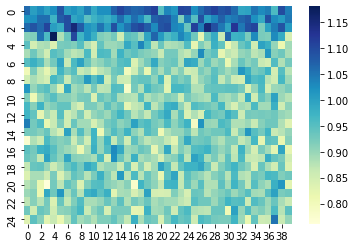

In [ ]:
wire_R = [(i+1)*2 for i in range(40)]
p_stuck = [0.01*(i) for i in range(40)]
R_std = [1e2*i for i in range(1, 101, 4)]


org_net_weight = net.fc1.W
org_net_bias = net.fc1.b

err_org = network_tester(net, testloader, 400, 0, False).item()
print(err_org)

result = []

for std in R_std:
    result_wire = []
    for var in p_stuck:
        device_params = {"Vdd": 1.8,
                 "r_wl": 20,
                 "r_bl": 20,
                 "m": 100,
                 "n": 100,
                 "r_on_mean": 1e4,
                 "r_on_stddev": std,
                 "r_off_mean": 1e5,
                 "r_off_stddev": std*10,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 6,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": var,
                 "p_stuck_off": var}
        crb_new = crossbar(device_params)

        net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
        net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

        net.fc1.cb = crb_new
        net.fc1.remap()

        err = network_tester(net, testloader, 400, 0, False).item()
        result_wire.append(err/err_org)

    result.append(result_wire)

print(result)
with open("result_non_ideal_RNN2.txt", 'w') as writefile:
    writefile.write(str(result))

ax = sns.heatmap(result, cmap="YlGnBu")
plt.show()

In [ ]:
res = [ele.numpy().tolist() for ele in c3f1_thr_per_batch2]
with open("result_output_threshold.txt", 'w') as writefile:
    writefile.write(str(res))

In [ ]:
trad_outputs = []
for i in range(1000):
    trad_outputs.append(net2(next(iter(testloader))[0]))
trad_plottable = []
for i in trad_outputs:
    for j in i[0]:
        trad_plottable.append(float(j.detach().numpy()))

with open("result_output_distribution_trad5.txt", 'w') as writefile:
    writefile.write(str(trad_plottable))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
thresh_outputs = []
for i in range(1000):
    thresh_outputs.append(net(next(iter(testloader))[0]))
thresh_plottable = []
for i in thresh_outputs:
    for j in i[0]:
        thresh_plottable.append(float(j.detach().numpy()))

with open("result_output_distribution_codex6.txt", 'w') as writefile:
    writefile.write(str(thresh_plottable))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
thresh_outputs, thresh_loss = [], []
for i in range(1000):
    item = next(iter(testloader))
    res = net3(item[0])
    thresh_outputs.append(res[0])
    loss_curr =  F.nll_loss(res, item[1])
    thresh_loss.append(loss_curr.item())

with open("err_codex_manh.txt", 'w') as writefile:
    writefile.write(str(thresh_loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
err2 = np.cumsum(thresh_loss)
print(thresh_loss[:3])
print(err2[:3])

[1.8103506565093994, 0.758525550365448, 0.2682112753391266]
[1.81035066 2.56887621 2.83708748]


In [ ]:
with open("err_codex_manh_cumsum.txt", 'w') as writefile:
    writefile.write(str(err2))

In [ ]:
manh_outputs = []
for i in range(500):
    manh_outputs.append(net3(next(iter(testloader))[0]))
manh_plottable = []
for i in manh_outputs:
    for j in i[0]:
        manh_plottable.append(float(j.detach().numpy()))

with open("result_output_distribution_manh.txt", 'w') as writefile:
    writefile.write(str(manh_plottable))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


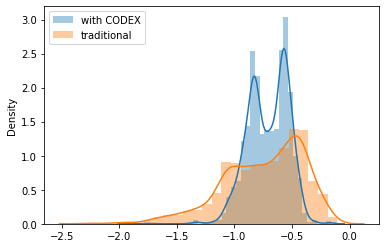

In [ ]:
import seaborn as sns
sns.distplot(thresh_plottable, label = 'with CODEX')
sns.distplot(trad_plottable, label = 'traditional')
#sns.distplot(manh_plottable, label = 'Manhattan')

plt.legend()

plt.xlabel=("Output")
plt.ylabel=("Frequency")

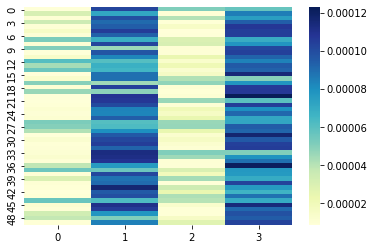

In [ ]:
ax = sns.heatmap(net.fc1.cb.W.detach().numpy()[:50,:4], cmap="YlGnBu")
plt.show()

with open("heatmap_thresh_RNN.txt", 'w') as writefile:
    writefile.write(str(net.fc1.cb.W.detach().numpy()[:50,:4]))

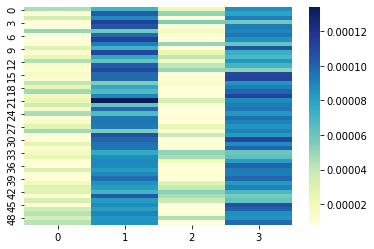

In [ ]:
ax = sns.heatmap(net.fc1.cb.W.detach().numpy()[:50,:4], cmap="YlGnBu")
plt.show()

with open("heatmap_thresh_RNN001.txt", 'w') as writefile:
    writefile.write(str(net.fc1.cb.W.detach().numpy()[:50,:4]))

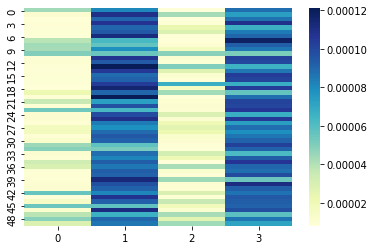

In [ ]:
ax = sns.heatmap(net.fc1.cb.W.detach().numpy()[:50,:4], cmap="YlGnBu")
plt.show()

with open("heatmap_thresh_RNN.txt", 'w') as writefile:
    writefile.write(str(net.fc1.cb.W.detach().numpy()[:50,:4]))

In [ ]:
train_config = {
    "num_epochs" : 45,
    "batch_size" : 100,
    "gamma" : 1,
    "naive_loss_thr" : 1,
    'learning_rate' : 0.0002,
    "log_interval" : 1000,
    "momentum": 0.9,
    "max_thresh_multiplier": 1.1,
    "test_interval": 10000,
}

# we know for this dataset the max n_epoch = 50,000
def calc_gamma(lr, m_epoch):
    return np.log(lr)/(-lr*m_epoch)

train_config['gamma'] = calc_gamma(train_config['learning_rate'], 50000)

with open('log_baseline_train3.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "train_loss", "train_acc"])

with open('log_baseline_test3.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "test_loss", "test_acc"])

with open('record3.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "update", "grad", "threshold"])

criterion = nn.CrossEntropyLoss()
net = TweetRNN(50, 50, 2)
trainloader = TweetBatcher(train, batch_size=1, drop_last=True)
testloader = TweetBatcher(valid, batch_size=1, drop_last=False)
c3f1_loss_per_epoch2, c3f1_update_per_epoch2, c3f1_every_loss2, c3f1_thr_per_batch2 = net_trainer(net, trainloader, testloader, train_config)

# model = TweetRNN(50, 50, 2)

# train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
# get_accuracy(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 iteration 0 Loss: 2.434 | Acc: 0.000% (0/1)
Epoch 0 iteration 100 Loss: 0.947 | Acc: 50.495% (51/101)
Epoch 0 iteration 200 Loss: 0.865 | Acc: 55.721% (112/201)
Test accuracy: 0.5572139024734497
Epoch: 1, Loss: 1.461568832397461 Updates: 0/0, Avg Grad: 0.23934757709503174, Threshold: 0.26328232884407043
Epoch: 1, Loss: 0.024587588384747505 Updates: 2/1000, Avg Grad: 0.14794102311134338, Threshold: 0.35156378149986267
Epoch: 1, Loss: 0.01572323404252529 Updates: 4/2000, Avg Grad: 0.03635737672448158, Threshold: 0.3700334131717682
Epoch: 1, Loss: 0.002937908982858062 Updates: 5/3000, Avg Grad: 0.11159443855285645, Threshold: 0.43685922026634216
Epoch: 1, Loss: 0.005956822074949741 Updates: 5/4000, Avg Grad: 0.4231644570827484, Threshold: 0.43685922026634216
Epoch: 1, Loss: 0.0015758919762447476 Updates: 6/5000, Avg Grad: 0.21581962704658508, Threshold: 0.5055859684944153
Epoch: 1, Loss: 0.005920419469475746 Updates: 6/6000, Avg Grad: 0.4165143072605133, Threshold: 0.5055859684944

In [ ]:
train_config = {
    "num_epochs" : 45,
    "batch_size" : 200,
    "gamma" : 1,
    "naive_loss_thr" : 1,
    'learning_rate' : 0.0008,
    "log_interval" : 1000,
    "momentum": 0.9,
    "max_thresh_multiplier": 1.1,
    "test_interval": 10000,
}

# we know for this dataset the max n_epoch = 50,000
def calc_gamma(lr, m_epoch):
    return np.log(lr)/(-lr*m_epoch)

train_config['gamma'] = calc_gamma(train_config['learning_rate'], 50000)

with open('log_baseline_train2.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "train_loss", "train_acc"])

with open('log_baseline_test2.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "test_loss", "test_acc"])

with open('record.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "update", "grad", "threshold"])

criterion = nn.CrossEntropyLoss()
net3 = TweetRNN(50, 50, 2)
trainloader = TweetBatcher(train, batch_size=1, drop_last=True)
validloader = TweetBatcher(valid, batch_size=1, drop_last=False)
testloader = TweetBatcher(test, batch_size=1, drop_last=False)
c3f1_loss_per_epoch2, c3f1_update_per_epoch2, c3f1_every_loss2, c3f1_thr_per_batch2 = net_trainer3(net3, trainloader, validloader, train_config)

# model = TweetRNN(50, 50, 2)

# train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
# get_accuracy(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 iteration 0 Loss: 1.611 | Acc: 0.000% (0/1)
Epoch 0 iteration 100 Loss: 1.179 | Acc: 40.594% (41/101)
Epoch 0 iteration 200 Loss: 1.156 | Acc: 40.299% (81/201)
Epoch 0 iteration 300 Loss: 1.071 | Acc: 45.847% (138/301)
Epoch 0 iteration 400 Loss: 1.085 | Acc: 44.140% (177/401)
Epoch 0 iteration 500 Loss: 1.071 | Acc: 45.709% (229/501)
Test accuracy: 0.45708581805229187
Epoch: 1, Loss: 0.0014463725965470076 Updates: 1/1, Avg Grad: 0.00040840118890628220
Epoch: 1, Loss: 0.002563933841884136 Updates: 6/1001, Avg Grad: 0.039178155362606050
Epoch: 1, Loss: 0.002838392276316881 Updates: 11/2001, Avg Grad: 0.0136977145448327060
Epoch: 1, Loss: 0.0034989137202501297 Updates: 16/3001, Avg Grad: 0.0133654652163386340
Epoch: 1, Loss: 0.0029715404380112886 Updates: 21/4001, Avg Grad: 0.0119735272601246830
Epoch: 1, Loss: 0.0032116887159645557 Updates: 26/5001, Avg Grad: 0.0128757860511541370
Epoch: 1, Loss: 0.002840035827830434 Updates: 31/6001, Avg Grad: 0.015868144109845160
Epoch: 1, Los

## Non-ideality considerations

In [ ]:
org_net_weight = net.fc1.W
org_net_bias = net.fc1.b

In [ ]:
org_net_weight = net.fc1.W
org_net_bias = net.fc1.b

DAC_res = [4, 5, 6, 7]
ADC_res = [6 + 0.2 * i for i in range(16)]
device_resolution = [3,4,5,6,7,8]
testloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)

err_org = network_tester(net, testloader, 400, 0, False).item()
print(err_org)

result = []

for idx in range(6):
    for res in device_resolution:
      result_wire = []
      for adc in range(1): #adc in range(20)
          device_params = {"Vdd": 1.8,
                  "r_wl": 20,
                  "r_bl": 20,
                  "m": 200,
                  "n": 200,
                  "r_on_mean": 1e4,
                  "r_on_stddev": 1e3,
                  "r_off_mean": 1e5,
                  "r_off_stddev": 1e4,
                  "dac_resolution": 4,
                  "adc_resolution": 8.3,
                  "device_resolution": res,
                  "bias_scheme": 1/3,
                  "tile_rows": 4,
                  "tile_cols": 4,
                  "r_cmos_line": 600,
                  "r_cmos_transistor": 20,
                  "p_stuck_on": 0.01,
                  "p_stuck_off": 0.01}
          crb_new = crossbar(device_params)

          net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
          net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

          net.fc1.cb = crb_new
          net.fc1.remap()

          err = network_tester(net, testloader, 400, 0, False).item()
          result_wire.append(err/err_org)

      result.append(result_wire)

    file_name = 'recordenob' + str(idx) + '.csv'
    with open(file_name, 'w') as f:
      writer = csv.writer(f)
      writer.writerow([])

    for ele in result:
      with open(file_name, 'a') as f:
          writer = csv.writer(f)
          writer.writerow(ele)
print(result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.6359102129936218
[[0.9921568520854682], [0.9725490291647526], [0.9921568520854682], [0.8549019979092313], [1.0862745333286217], [0.909803939579726], [1.0196078229207157], [0.8039215833303887], [0.8156862583365725], [1.0196078229207157], [0.9333333833233213], [0.8549019979092313], [1.0980392083348056], [1.0627450895850266], [0.7843137604096729], [1.0117647687374114], [0.941176531237853], [1.0078431479145318], [1.031372591658127], [0.9725490291647526], [1.0117647687374114], [1.0078431479145318], [0.8000000562387365], [0.8705882937382947], [0.7882352875013251], [1.1294117999929327], [0.7882352875013251], [1.0666667104079062], [0.8509803770863517], [0.9843137041709366], [0.7921569083242047], [0.9647058812502208], [1.0039216208228796], [1.0392157395726587], [0.9372549104149734], [1.035294118749779]]


In [ ]:
# crossbar update
device_params = {"Vdd": 1.8,
                 "r_wl": 20,
                 "r_bl": 20,
                 "m": 200,
                 "n": 200,
                 "r_on_mean": 1e4,
                 "r_on_stddev": 1e3,
                 "r_off_mean": 1e5,
                 "r_off_stddev": 1e4,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 6,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01}
crb_new = crossbar(device_params)

net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

net.fc1.cb = crb_new
net.fc1.remap()

In [ ]:
DAC_res = [4, 5, 6, 7]
ADC_res = [6 + 0.2 * i for i in range(16)]
device_resolution = [3,4,5,6,7,8]
testloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)

err_org = network_tester(net, testloader, 400, 0, False).item()
print(err_org)

result = []

for idx in range(6):
    for res in DAC_res:
      result_wire = []
      for adc in range(1): #adc in range(20)
          device_params = {"Vdd": 1.8,
                  "r_wl": 20,
                  "r_bl": 20,
                  "m": 200,
                  "n": 200,
                  "r_on_mean": 1e4,
                  "r_on_stddev": 1e3,
                  "r_off_mean": 1e5,
                  "r_off_stddev": 1e4,
                  "dac_resolution": res,
                  "adc_resolution": 8.3,
                  "device_resolution": 6,
                  "bias_scheme": 1/3,
                  "tile_rows": 4,
                  "tile_cols": 4,
                  "r_cmos_line": 600,
                  "r_cmos_transistor": 20,
                  "p_stuck_on": 0.01,
                  "p_stuck_off": 0.01}
          crb_new = crossbar(device_params)

          net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
          net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

          net.fc1.cb = crb_new
          net.fc1.remap()

          err = network_tester(net, testloader, 400, 0, False).item()
          result_wire.append(err/err_org)

      result.append(result_wire)

    file_name = 'recorddac' + str(idx) + '.csv'
    with open(file_name, 'w') as f:
      writer = csv.writer(f)
      writer.writerow([])

    for ele in result:
      with open(file_name, 'a') as f:
          writer = csv.writer(f)
          writer.writerow(ele)
print(result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.6857855319976807
[[0.9636364015626515], [0.7963636227733832], [1.0836363459374292], [0.9709091386330032], [0.9090909169922191], [0.9599999895702708], [0.9418181903515966], [0.9709091386330032], [0.9054545919142482], [0.8181818339844381], [0.9599999895702708], [0.9527272524999192], [0.8618181694921383], [0.7818181486326798], [0.9490909274219482], [0.8981818548438965], [0.7381818131249798], [1.0363636853517582], [0.9563636644922999], [0.7636363494140057], [0.8945454428515157], [0.8036363598437348], [0.7200000139063055], [0.9163636540625707]]


In [ ]:
# crossbar update
device_params = {"Vdd": 1.8,
                 "r_wl": 20,
                 "r_bl": 20,
                 "m": 200,
                 "n": 200,
                 "r_on_mean": 1e4,
                 "r_on_stddev": 1e3,
                 "r_off_mean": 1e5,
                 "r_off_stddev": 1e4,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 6,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01}
crb_new = crossbar(device_params)

net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

net.fc1.cb = crb_new
net.fc1.remap()

In [ ]:
DAC_res = [4, 5, 6, 7]
ADC_res = [6 + 0.2 * i for i in range(16)]
device_resolution = [3,4,5,6,7,8]
testloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)

err_org = network_tester(net, testloader, 400, 0, False).item()
print(err_org)

result = []

for idx in range(6):
    for res in ADC_res:
      result_wire = []
      for adc in range(1): #adc in range(20)
          device_params = {"Vdd": 1.8,
                  "r_wl": 20,
                  "r_bl": 20,
                  "m": 200,
                  "n": 200,
                  "r_on_mean": 1e4,
                  "r_on_stddev": 1e3,
                  "r_off_mean": 1e5,
                  "r_off_stddev": 1e4,
                  "dac_resolution": 5,
                  "adc_resolution": res,
                  "device_resolution": 6,
                  "bias_scheme": 1/3,
                  "tile_rows": 4,
                  "tile_cols": 4,
                  "r_cmos_line": 600,
                  "r_cmos_transistor": 20,
                  "p_stuck_on": 0.01,
                  "p_stuck_off": 0.01}
          crb_new = crossbar(device_params)

          net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
          net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

          net.fc1.cb = crb_new
          net.fc1.remap()

          err = network_tester(net, testloader, 400, 0, False).item()
          result_wire.append(err/err_org)

      result.append(result_wire)

    file_name = 'recordadc' + str(idx) + '.csv'
    with open(file_name, 'w') as f:
      writer = csv.writer(f)
      writer.writerow([])

    for ele in result:
      with open(file_name, 'a') as f:
          writer = csv.writer(f)
          writer.writerow(ele)
print(result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.6284289360046387
[[0.9563491958106427], [0.9126983916212855], [0.9880952697109289], [0.9801587512358574], [1.0992063386677855], [1.0992063386677855], [1.1031745504817851], [0.7738095080016784], [1.027777767239214], [0.996031693338928], [1.015873036950143], [0.9484126773355712], [0.9682539260997138], [1.0198412487641426], [0.8650793756179287], [1.075396783242571], [1.0634920529535], [1.0674602647674996], [0.920634910096357], [1.0436508041893573], [0.9007936613322144], [0.8571428571428571], [0.9801587512358574], [0.8373016083787145], [1.1190475874319283], [0.9246031219103567], [0.9166666982823575], [0.9007936613322144], [0.9801587512358574], [0.9523809839966432], [1.138888836196071], [1.1349206243820713], [1.0436508041893573], [0.9801587512358574], [1.0595238411395003], [1.1428571428571428], [0.9365079470465001], [0.8928571428571429], [0.9523809839966432], [1.0714285714285714], [1.091269820192714], [1.1150793756179287], [0.9642857142857143], [0.8769841059069998], [1.0634920529535], [0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.6857855319976807
[[0.7018181712304264], [0.7818181486326798], [0.5672727092577405], [0.6909091090821039], [0.5490909100390663], [0.5999999826171181]]


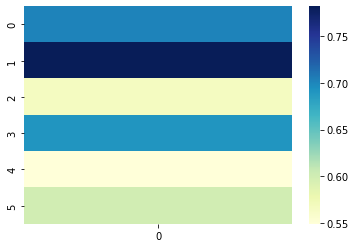

In [ ]:
# crossbar update
device_params = {"Vdd": 1.8,
                 "r_wl": 20,
                 "r_bl": 20,
                 "m": 100,
                 "n": 100,
                 "r_on_mean": 1e4,
                 "r_on_stddev": 1e3,
                 "r_off_mean": 1e5,
                 "r_off_stddev": 1e4,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 6,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01}
crb_new = crossbar(device_params)

net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

net.fc1.cb = crb_new
net.fc1.remap()

DAC_res = [4, 5, 6, 7]
ADC_res = [6 + 0.2 * i for i in range(16)]
device_resolution = [3,4,5,6,7,8]
testloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)
err_org = network_tester(net3, testloader, 400, 0, False).item()
print(err_org)

result = []

for res in device_resolution:
    result_wire = []
    for adc in range(1): #adc in range(20)
        device_params = {"Vdd": 1.8,
                 "r_wl": 20,
                 "r_bl": 20,
                 "m": 200,
                 "n": 200,
                 "r_on_mean": 1e4,
                 "r_on_stddev": 1e3,
                 "r_off_mean": 1e5,
                 "r_off_stddev": 1e4,
                 "dac_resolution": 4,
                 "adc_resolution": 8.3,
                 "device_resolution": res,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01}
        crb_new = crossbar(device_params)

        net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
        net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

        net.fc1.cb = crb_new
        net.fc1.remap()

        err = network_tester(net, testloader, 400, 0, False).item()
        result_wire.append(err/err_org)

    result.append(result_wire)

print(result)

with open('recordenob5.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow([])

for ele in result:
  with open('recordenob5.csv', 'a') as f:
      writer = csv.writer(f)
      writer.writerow(ele)

ax = sns.heatmap(result, cmap="YlGnBu")
plt.show()